In [ ]:
import duckdb
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql.types import StructType,StructField,IntegerType,LongType,DoubleType,BooleanType,TimestampType
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
spark = SparkSession.builder.appName('Companies').getOrCreate()

1. QUAN SÁT VÀ PHÂN TÍCH BẢNG DIM_COMPANIES

In [70]:
# Connect to Datawarehouse
duck_conn = duckdb.connect('/home/thangtranquoc/stock_elt_project/datawarehouse.duckdb')
query = 'SELECT * FROM dim_companies'
# Fetch data from DW and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()
duck_conn.close()

In [71]:
# Convert Pandas DataFrame to PySpark DataFrame
spark_df_companies = spark.createDataFrame(pandas_df)
print(spark_df_companies.count())

# Show the Spark DataFrame
spark_df_companies.show()

20306
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|    company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+--------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|         1|AGILENT TECHNOLOG...|2025-06-20 10:01:...|             A|              false|Domestic Common S...|             USD|   California; U.S.A|         

In [72]:
# Create Window Specification
windowSpec = Window.partitionBy('company_ticket').orderBy(spark_df_companies['company_time_stamp'].desc())

# Sử dụng row_number để đánh số thứ tự và giữ lại hàng cuối cùng
df_with_row_num = spark_df_companies.withColumn('row_num',f.row_number().over(windowSpec))

# Lọc để giữ lại hàng cuối cùng trong mỗi nhóm
spark_df_companies_filtered = df_with_row_num.filter(df_with_row_num.row_num == 1).drop('row_num')

print(spark_df_companies_filtered.count())
spark_df_companies_filtered.show()

20306
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+-------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|   company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+-------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|         2|          ALCOA CORP|2025-06-20 10:01:...|            AA|              false|Domestic Common S...|             USD|Pennsylvania; U.S.A|             

In [73]:
# Thống kê số lượng công ty ở từng sàn giao dịch
print('Thống kê số lượng công ty ở từng sàn giao dịch')
spark_df_companies_filtered \
    .groupBy('company_exchange_name') \
    .agg(f.count('*').alias('count')) \
    .withColumnRenamed('company_exchange_name','Sàn giao dịch') \
    .withColumnRenamed('count','Số lượng mã niêm yết') \
    .show()

Thống kê số lượng công ty ở từng sàn giao dịch
+-------------+--------------------+
|Sàn giao dịch|Số lượng mã niêm yết|
+-------------+--------------------+
|         NYSE|                6658|
|       NASDAQ|               13648|
+-------------+--------------------+



In [74]:
# Thống kê số lượng công ty đã và chưa bị delisted
print('Thống kê số lượng công ty đã và chưa bị hủy niêm yết')
spark_df_companies_filtered \
    .groupBy('company_is_delisted') \
    .agg(f.count('*').alias('count')) \
    .withColumnRenamed('company_is_delisted', 'Đã bị hủy niêm yết') \
    .withColumnRenamed('count', 'Số lượng công ty') \
    .show()

Thống kê số lượng công ty đã và chưa bị hủy niêm yết
+------------------+----------------+
|Đã bị hủy niêm yết|Số lượng công ty|
+------------------+----------------+
|              true|           14086|
|             false|            6220|
+------------------+----------------+



In [75]:
# Thống kê số lượng công ty theo quốc gia
print('Thống kê số lượng công ty theo quốc gia')
spark_df_companies_filtered \
    .withColumn('Quốc Gia', f.element_at(f.split(spark_df_companies_filtered['company_location'],"; "), -1)) \
    .drop('company_location') \
    .groupBy('Quốc Gia') \
    .agg(f.count('*').alias('count')) \
    .orderBy(f.col('count').desc()) \
    .withColumnRenamed('count', 'Số lượng công ty') \
    .show()

Thống kê số lượng công ty theo quốc gia
+--------------+----------------+
|      Quốc Gia|Số lượng công ty|
+--------------+----------------+
|         U.S.A|           16915|
|         China|             586|
|        Canada|             547|
|United Kingdom|             279|
|        Israel|             237|
|Cayman Islands|             207|
|       Bermuda|             183|
|     Hong Kong|             133|
|     Singapore|             110|
|       Ireland|              83|
|        Brazil|              74|
|     Australia|              65|
|   Netherlands|              63|
|       Germany|              57|
|    Luxembourg|              53|
|         Japan|              49|
|        Greece|              47|
|   Switzerland|              46|
|        Taiwan|              45|
|        Mexico|              45|
+--------------+----------------+
only showing top 20 rows


In [76]:
# Thống kê số lượng công ty theo ngành công nghiệp
print('Thống kê số lượng công ty theo ngành công nghiệp')
spark_df_companies_filtered \
    .groupBy('company_industry_sector') \
    .agg(f.count('*').alias('count')) \
    .orderBy(f.col('count').desc()) \
    .withColumnRenamed('company_industry_sector','Ngành công nghiệp') \
    .withColumnRenamed('count' , 'Số lượng công ty') \
    .show()

Thống kê số lượng công ty theo ngành công nghiệp
+--------------------+----------------+
|   Ngành công nghiệp|Số lượng công ty|
+--------------------+----------------+
|         Industrials|            3894|
|          Technology|            3493|
|          Healthcare|            3051|
|  Financial Services|            2954|
|   Consumer Cyclical|            1901|
|Communication Ser...|            1158|
|         Real Estate|            1016|
|              Energy|             855|
|     Basic Materials|             852|
|  Consumer Defensive|             758|
|           Utilities|             374|
+--------------------+----------------+



In [77]:
# Thống kê số lượng công ty theo ngành công nghiệp sic
print('Thống kê số lượng công ty theo ngành công nghiệp Sic')
spark_df_companies_filtered \
    .groupBy('company_sic_sector') \
    .agg(f.count('*').alias('count')) \
    .orderBy(f.col('count').desc()) \
    .withColumnRenamed('company_sic_sector', 'Ngành công nghiệp Sic') \
    .withColumnRenamed('count' , 'Số lượng công ty') \
    .show()

Thống kê số lượng công ty theo ngành công nghiệp Sic
+---------------------+----------------+
|Ngành công nghiệp Sic|Số lượng công ty|
+---------------------+----------------+
|        Manufacturing|            6571|
| Finance Insurance...|            5921|
|             Services|            3891|
| Transportation Co...|            1645|
|         Retail Trade|             877|
|               Mining|             723|
|      Wholesale Trade|             430|
|         Construction|             176|
| Agriculture Fores...|              72|
+---------------------+----------------+



In [78]:
# Thống kê số lượng công ty theo loại hình công ty
print('Thống kê số lượng công ty theo loại hình công ty')
spark_df_companies_filtered \
    .groupBy('company_category') \
    .agg(f.count('*').alias('count')) \
    .orderBy(f.col('count').desc()) \
    .withColumnRenamed('company_category', 'Loại hình công ty') \
    .withColumnRenamed('count' , 'Số lượng công ty') \
    .show()

Thống kê số lượng công ty theo loại hình công ty
+--------------------+----------------+
|   Loại hình công ty|Số lượng công ty|
+--------------------+----------------+
|Domestic Common S...|           12333|
|Domestic Common S...|            1897|
|    ADR Common Stock|            1604|
|Domestic Common S...|            1371|
|Domestic Common S...|            1097|
|Domestic Preferre...|            1055|
|Canadian Common S...|             256|
|ADR Common Stock ...|             240|
|ADR Common Stock ...|             202|
|ADR Common Stock ...|             140|
| ADR Preferred Stock|              90|
|Canadian Common S...|              11|
|Canadian Common S...|               5|
|Canadian Preferre...|               3|
|Canadian Common S...|               2|
+--------------------+----------------+



2. QUAN SÁT VÀ PHÂN TÍCH BẢNG FACT_CANDLES

In [79]:
# Connect to fact_candles table in DW
duck_conn = duckdb.connect('/home/thangtranquoc/stock_elt_project/datawarehouse.duckdb')
query = 'SELECT * FROM fact_candles'

# Fetch data from DW and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()
duck_conn.close()

In [80]:
pandas_df

,candle_id,candle_company_id,candle_volume,candle_volume_weighted,candle_open,candle_close,candle_high,candle_low,candle_time_stamp,candle_num_of_trades,candle_is_otc,candles_time_id
0,1,1,1560338,115.912000,116.0900,115.5200,116.8800,114.6650,1750276800000,26292,<NA>,1
1,2,2,5634805,28.428000,28.6300,28.3500,28.8500,28.1300,1750276800000,48112,<NA>,1
2,3,11,25505,10.140000,10.1400,10.1400,10.1400,10.1400,1750276800000,13,<NA>,1
3,4,13,475026,11.299900,11.3100,11.3000,11.3100,11.2900,1750276800000,422,<NA>,1
4,5,15,240,0.000683,0.0001,0.0015,0.0015,0.0001,1750276800000,2,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12076,12077,20287,933644,25.963800,26.0700,25.9400,26.1900,25.9400,1750449600000,5484,<NA>,2
12077,12078,20288,38419,3.053700,2.9800,3.1700,3.1700,2.9100,1750449600000,298,<NA>,2
12078,12079,20299,23952,1.333900,1.3400,1.3250,1.3504,1.3200,1750449600000,130,<NA>,2
12079,12080,20300,1145850,17.218600,17.1900,17.2100,17.3300,17.1500,1750449600000,10689,<NA>,2


In [81]:
# Loại bỏ các cột thừa không cần thiết trong phân tích
pandas_df.drop(columns=['candles_time_id'],inplace=True)

# Chuyển đổi các cột dữ liệu
pandas_df['candle_is_otc'] = pandas_df['candle_is_otc'].fillna(False).astype(bool)
pandas_df['candle_time_stamp'] = pd.to_datetime(pandas_df['candle_time_stamp'],unit='ms')

pandas_df

/tmp/ipykernel_1899/4178809639.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  pandas_df['candle_time_stamp'] = pd.to_datetime(pandas_df['candle_time_stamp'],unit='ms')


,candle_id,candle_company_id,candle_volume,candle_volume_weighted,candle_open,candle_close,candle_high,candle_low,candle_time_stamp,candle_num_of_trades,candle_is_otc
0,1,1,1560338,115.912000,116.0900,115.5200,116.8800,114.6650,2025-06-18 20:00:00,26292,False
1,2,2,5634805,28.428000,28.6300,28.3500,28.8500,28.1300,2025-06-18 20:00:00,48112,False
2,3,11,25505,10.140000,10.1400,10.1400,10.1400,10.1400,2025-06-18 20:00:00,13,False
3,4,13,475026,11.299900,11.3100,11.3000,11.3100,11.2900,2025-06-18 20:00:00,422,False
4,5,15,240,0.000683,0.0001,0.0015,0.0015,0.0001,2025-06-18 20:00:00,2,True
...,...,...,...,...,...,...,...,...,...,...,...
12076,12077,20287,933644,25.963800,26.0700,25.9400,26.1900,25.9400,2025-06-20 20:00:00,5484,False
12077,12078,20288,38419,3.053700,2.9800,3.1700,3.1700,2.9100,2025-06-20 20:00:00,298,False
12078,12079,20299,23952,1.333900,1.3400,1.3250,1.3504,1.3200,2025-06-20 20:00:00,130,False
12079,12080,20300,1145850,17.218600,17.1900,17.2100,17.3300,17.1500,2025-06-20 20:00:00,10689,False


In [82]:
# Xác định các Schema
schema = StructType ([
    StructField('candle_id',IntegerType(),True),
    StructField('candle_company_id',IntegerType(),True),
    StructField('candle_volume',LongType(),True),
    StructField('candle_volume_weighted',DoubleType(),True),
    StructField('candle_open',DoubleType(),True),
    StructField('candle_close',DoubleType(),True),
    StructField('candle_high',DoubleType(),True),
    StructField('candle_low',DoubleType(),True),
    StructField('candle_time_stamp',TimestampType(),True),
    StructField('candle_num_of_trades',IntegerType(),True),
    StructField('candle_is_otc',BooleanType(),True)
])

# Chuyển đổi Pandas DataFrame thành PySpark DataFrame với schema được định nghĩa sẵn
spark_df_candles = spark.createDataFrame(pandas_df,schema=schema)

# Hiển thị 1 vài dòng dữ liệu của DataFrame
print(spark_df_candles.count())
spark_df_candles.show()

12081
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+-------------------+--------------------+-------------+
|candle_id|candle_company_id|candle_volume|candle_volume_weighted|candle_open|candle_close|candle_high|candle_low|  candle_time_stamp|candle_num_of_trades|candle_is_otc|
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+-------------------+--------------------+-------------+
|        1|                1|      1560338|               115.912|     116.09|      115.52|     116.88|   114.665|2025-06-18 20:00:00|               26292|        false|
|        2|                2|      5634805|                28.428|      28.63|       28.35|      28.85|     28.13|2025-06-18 20:00:00|               48112|        false|
|        3|               11|        25505|                 10.14|      10.14|       10.14|      10.14|     10.14|2025-06-18 20:00:00|          

In [83]:
# Thống kê số lượng cổ phiếu được giao dịch trong ngày
print('Thống kê số lượng cổ phiếu được giao dịch trong ngày')
spark_df_candles \
    .withColumn('Ngày giao dịch',f.to_date(f.col('candle_time_stamp'))) \
    .groupBy('Ngày giao dịch') \
    .agg(
        f.sum('candle_volume').alias('Tổng khối lượng cổ phiếu được giao dịch trong ngày'),
        f.sum('candle_num_of_trades').alias('Tổng số giao dịch được thực hiện'),
        f.sum(f.when(f.col('candle_is_otc') == True,1).otherwise(0)).alias('Số lượng mã OTC')
    ) \
    .orderBy(f.col('Ngày giao dịch')) \
    .show()

Thống kê số lượng cổ phiếu được giao dịch trong ngày
+--------------+--------------------------------------------------+--------------------------------+---------------+
|Ngày giao dịch|Tổng khối lượng cổ phiếu được giao dịch trong ngày|Tổng số giao dịch được thực hiện|Số lượng mã OTC|
+--------------+--------------------------------------------------+--------------------------------+---------------+
|    2025-06-18|                                       12424742423|                        81755667|            408|
|    2025-06-20|                                       17064774032|                        84797135|            399|
+--------------+--------------------------------------------------+--------------------------------+---------------+



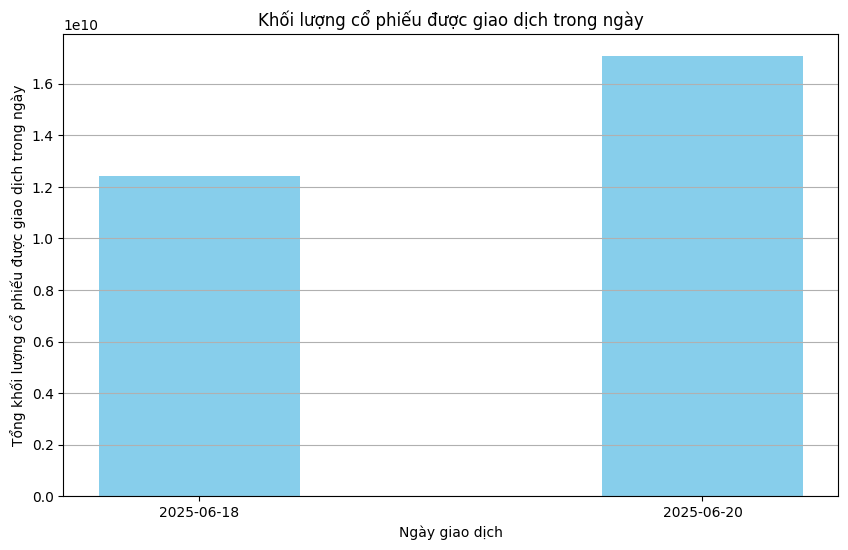

In [84]:
result_df = spark_df_candles \
    .withColumn('Ngày giao dịch',f.to_date(f.col('candle_time_stamp'))) \
    .groupBy('Ngày giao dịch') \
    .agg(
        f.sum('candle_volume').alias('Tổng khối lượng cổ phiếu được giao dịch trong ngày'),
        f.sum('candle_num_of_trades').alias('Tổng số giao dịch được thực hiện'),
        f.sum(f.when(f.col('candle_is_otc') == True,1).otherwise(0)).alias('Số lượng mã OTC')
    ) \
    .orderBy(f.col('Ngày giao dịch')) \
    .toPandas()

# Vẽ biểu đồ thống kê
plt.figure(figsize=(10,6))
plt.bar(result_df['Ngày giao dịch'],result_df['Tổng khối lượng cổ phiếu được giao dịch trong ngày'],color='skyblue')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Tổng khối lượng cổ phiếu được giao dịch trong ngày')
plt.title('Khối lượng cổ phiếu được giao dịch trong ngày')
plt.xticks(result_df['Ngày giao dịch'])
plt.grid(axis='y')
plt.show()

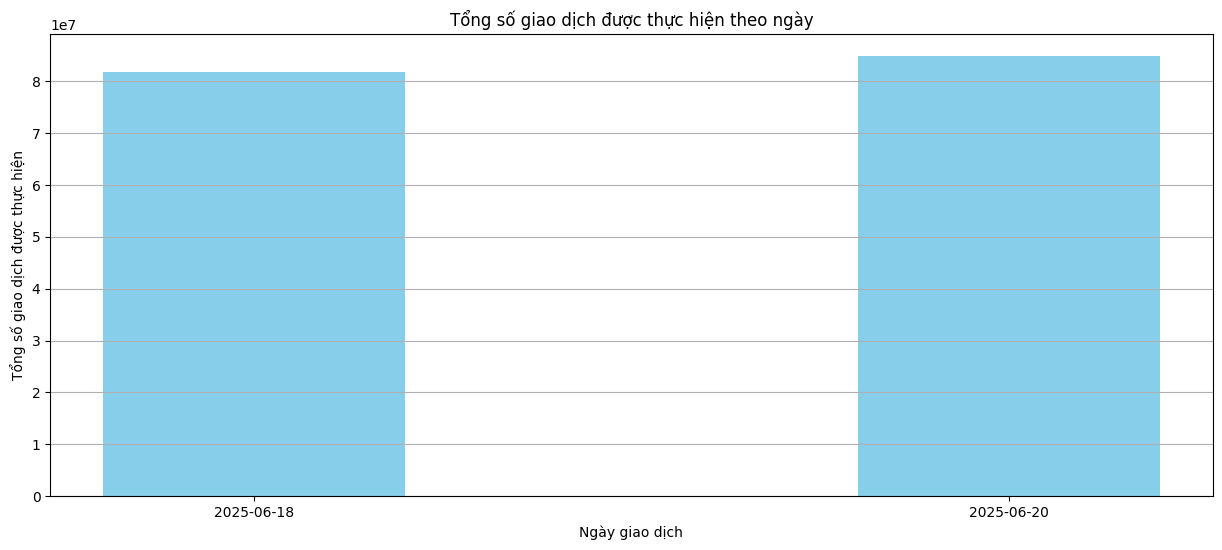

In [85]:
# Thống kê số lượng giao dịch cổ phiếu trong ngày
result_df = spark_df_candles \
    .withColumn('Ngày giao dịch',f.to_date(f.col('candle_time_stamp'))) \
    .groupBy('Ngày giao dịch') \
    .agg(
        f.sum('candle_volume').alias('Tổng khối lượng cổ phiếu được giao dịch trong ngày'),
        f.sum('candle_num_of_trades').alias('Tổng số giao dịch được thực hiện'),
        f.sum(f.when(f.col('candle_is_otc') == True,1).otherwise(0)).alias('Số lượng mã OTC')
    ) \
    .orderBy(f.col('Ngày giao dịch')) \
    .toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(15,6))
plt.bar(result_df['Ngày giao dịch'],result_df['Tổng số giao dịch được thực hiện'],color='skyblue')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Tổng số giao dịch được thực hiện')
plt.title('Tổng số giao dịch được thực hiện theo ngày')
plt.xticks(result_df['Ngày giao dịch'])
plt.grid(axis='y')
plt.show()

3. PHÂN TÍCH KẾT HỢP 2 BẢNG DIM_COMPANIES VÀ FACT_CANDLES

In [86]:
# Join 2 bảng dựa trên company_id và candle_company_id
joined_df = spark_df_candles.join(spark_df_companies_filtered,spark_df_candles.candle_company_id == spark_df_companies_filtered.company_id)

# Hiển thị 1 vài hàng của DataFrame kết hợp
joined_df.show()

+---------+-----------------+-------------+----------------------+-----------+------------+-----------+----------+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------+-------------------+--------------------+----------------+-------------------+---------------------+-------------------+---------------------+-----------------------+--------------------+--------------------+
|candle_id|candle_company_id|candle_volume|candle_volume_weighted|candle_open|candle_close|candle_high|candle_low|  candle_time_stamp|candle_num_of_trades|candle_is_otc|company_id|        company_name|  company_time_stamp|company_ticket|company_is_delisted|    company_category|company_currency|   company_location|company_exchange_name|company_region_name|company_industry_name|company_industry_sector|company_sic_industry|  company_sic_sector|
+---------+-----------------+-------------+----------------------+-----------+------------+-----------+-----

In [87]:
# Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp
print('Thống kê khối lượng giao dịch theo ngành công ngiệp')
joined_df \
    .groupBy('company_industry_sector') \
    .agg(f.round(f.avg('candle_volume')).alias('Khối lượng trung bình')) \
    .orderBy('Khối lượng trung bình',ascending = False) \
    .withColumnRenamed('company_industry_sector','Ngành') \
    .show()

Thống kê khối lượng giao dịch theo ngành công ngiệp
+--------------------+---------------------+
|               Ngành|Khối lượng trung bình|
+--------------------+---------------------+
|              Energy|            4477134.0|
|          Technology|            3401635.0|
|  Consumer Defensive|            3018799.0|
|     Basic Materials|            2839432.0|
|Communication Ser...|            2666518.0|
|           Utilities|            2660590.0|
|   Consumer Cyclical|            2516818.0|
|          Healthcare|            2097058.0|
|         Real Estate|            2013205.0|
|  Financial Services|            1989124.0|
|         Industrials|            1576866.0|
+--------------------+---------------------+



In [88]:
# Thống kê khối lượng giao dịch trung bình theo ngành công nghiệp Sic
joined_df \
    .groupBy('company_sic_sector') \
    .agg(f.round(f.avg('candle_volume')).alias('Khối lượng trung bình')) \
    .orderBy('Khối lượng trung bình',ascending = False) \
    .withColumnRenamed('company_sic_sector','Ngành công nghiệp Sic') \
    .show()

+---------------------+---------------------+
|Ngành công nghiệp Sic|Khối lượng trung bình|
+---------------------+---------------------+
|      Wholesale Trade|            5051237.0|
|               Mining|            4518316.0|
|             Services|            2844800.0|
| Transportation Co...|            2697353.0|
|        Manufacturing|            2465195.0|
|         Construction|            2334978.0|
|         Retail Trade|            2121113.0|
| Finance Insurance...|            1530406.0|
| Agriculture Fores...|             681644.0|
+---------------------+---------------------+



In [89]:
# Top 10 công ty có tổng khối lượng giao dịch nhiều nhất hiện tại
print('Top 10 công ty có tổng giao dịch nhiều nhất hiện tại')
joined_df \
    .groupBy('company_name') \
    .agg(
        f.sum('candle_volume').alias('Tổng khối lượng cổ phiếu được giao dịch'),
        f.sum('candle_num_of_trades').alias('Tổng số giao dịch được thực hiện')
    ) \
    .orderBy('Tổng khối lượng cổ phiếu được giao dịch', ascending = False) \
    .withColumnRenamed('company_name','Tên công ty') \
    .limit(10) \
    .show()

Top 10 công ty có tổng giao dịch nhiều nhất hiện tại
+--------------------+---------------------------------------+--------------------------------+
|         Tên công ty|Tổng khối lượng cổ phiếu được giao dịch|Tổng số giao dịch được thực hiện|
+--------------------+---------------------------------------+--------------------------------+
|HEALTHCARE TRIANG...|                             1038918896|                          112633|
|GREENLANE HOLDING...|                              523821023|                           51023|
|             PTL LTD|                              420873467|                          543665|
|         NVIDIA CORP|                              404450278|                         2640610|
|BIGBEARAI HOLDING...|                              373153028|                          278449|
|DRAGONFLY ENERGY ...|                              340086185|                          524044|
|          INTEL CORP|                              227673386|                     

4. QUAN SÁT VÀ PHÂN TÍCH BẢNG DIM_NEWS

In [90]:
# Connect to table dim_news in DW
duck_conn = duckdb.connect('/home/thangtranquoc/stock_elt_project/datawarehouse.duckdb')
query = 'SELECT * FROM dim_news'

# Fetch data from DuckDB and convert to Pandas DataFrame
pandas_df = duck_conn.execute(query).fetchdf()

duck_conn.close()

In [91]:
pandas_df.head()

,new_id,new_title,new_url,new_time_published,new_authors,new_summary,new_source,new_overall_sentiment_score,new_overall_sentiment_label,news_time_id
0,1,"TOM BRADY, JIM GRAY AND JEFFREY SOFFER UNVEIL ...",https://www.benzinga.com/pressreleases/25/06/n...,20250618T235400,[PRNewswire],The first-of-its kind museum officially opens ...,Benzinga,0.440587,Bullish,1
1,2,$100 Invested In IES Hldgs 10 Years Ago Would ...,https://www.benzinga.com/insights/news/25/06/4...,20250618T234516,[Benzinga Insights],IES Hldgs IESC has outperformed the market ove...,Benzinga,0.247763,Somewhat-Bullish,1
2,3,What Drives Stock Outperformance?,https://www.zacks.com/stock/news/2512563/what-...,20250618T233500,[Derek Lewis],Finding big-time winners is much easier said t...,Zacks Commentary,0.550885,Bullish,1
3,4,BOAT ROCKER AND BLUE ANT PROVIDE TRANSACTION U...,https://www.benzinga.com/pressreleases/25/06/n...,20250618T231600,[PRNewswire],"TORONTO, June 18, 2025 /CNW/ - Boat Rocker Med...",Benzinga,0.159734,Somewhat-Bullish,1
4,5,$100 Invested In This Stock 10 Years Ago Would...,https://www.benzinga.com/insights/news/25/06/4...,20250618T231516,[Benzinga Insights],Shopify SHOP has outperformed the market over ...,Benzinga,0.250000,Somewhat-Bullish,1


In [92]:
# loại bỏ các cột không cần thiết trong tính toán
pandas_df.drop(columns=['new_title','new_url','new_authors','new_summary','news_time_id'],inplace=True)

# Chuyển đổi kiểu dữ liệu

pandas_df['new_time_published'] = pd.to_datetime(pandas_df['new_time_published'],format = '%Y%m%dT%H%M%S')

pandas_df.head()

,new_id,new_time_published,new_source,new_overall_sentiment_score,new_overall_sentiment_label
0,1,2025-06-18 23:54:00,Benzinga,0.440587,Bullish
1,2,2025-06-18 23:45:16,Benzinga,0.247763,Somewhat-Bullish
2,3,2025-06-18 23:35:00,Zacks Commentary,0.550885,Bullish
3,4,2025-06-18 23:16:00,Benzinga,0.159734,Somewhat-Bullish
4,5,2025-06-18 23:15:16,Benzinga,0.250000,Somewhat-Bullish


In [93]:
# Convert Pandas DataFrame into PySpark DataFrame with schema
spark_df_news = spark.createDataFrame(pandas_df)

# Hiển thị 1 vài dòng của DataFrame
print(spark_df_news.count())
spark_df_news.show()

1975
+------+-------------------+--------------------+---------------------------+---------------------------+
|new_id| new_time_published|          new_source|new_overall_sentiment_score|new_overall_sentiment_label|
+------+-------------------+--------------------+---------------------------+---------------------------+
|     1|2025-06-18 23:54:00|            Benzinga|                   0.440587|                    Bullish|
|     2|2025-06-18 23:45:16|            Benzinga|                   0.247763|           Somewhat-Bullish|
|     3|2025-06-18 23:35:00|    Zacks Commentary|                   0.550885|                    Bullish|
|     4|2025-06-18 23:16:00|            Benzinga|                   0.159734|           Somewhat-Bullish|
|     5|2025-06-18 23:15:16|            Benzinga|                       0.25|           Somewhat-Bullish|
|     6|2025-06-18 23:08:00|    Zacks Commentary|                    0.01008|                    Neutral|
|     7|2025-06-18 23:00:45|South China M

In [96]:
# Thống kê số lượng bài báo từ các nguồn
print('Thống kê số lượng bài báo từ các nguồn')
spark_df_news \
    .groupBy('new_source') \
    .agg(f.count('*').alias('Tổng số bài báo được phát hành')) \
    .orderBy('Tổng số bài báo được phát hành',ascending = False) \
    .withColumnRenamed('new_source','Nguồn') \
    .show()

Thống kê số lượng bài báo từ các nguồn
+--------------------+------------------------------+
|               Nguồn|Tổng số bài báo được phát hành|
+--------------------+------------------------------+
|    Zacks Commentary|                           737|
|            Benzinga|                           725|
|       GlobeNewswire|                           270|
|         Motley Fool|                           103|
|       Cointelegraph|                            49|
|    Business Insider|                            37|
|          Decrypt.co|                            27|
|                CNBC|                            15|
|South China Morni...|                            10|
|     Financial Times|                             1|
|      Economic Times|                             1|
+--------------------+------------------------------+



In [97]:
# Thống kê số lượng bài báo theo các khung giờ
print('Thống kê số lượng bài báo theo các khung giờ')
result_df = spark_df_news \
    .withColumn('hour',f.hour('new_time_published')) \
    .groupBy('hour') \
    .agg(f.count('new_id').alias('Tổng số bài báo được phát hành')) \
    .withColumnRenamed('hour','Khung giờ') \
    .orderBy('Khung giờ') \
    .show()

Thống kê số lượng bài báo theo các khung giờ
+---------+------------------------------+
|Khung giờ|Tổng số bài báo được phát hành|
+---------+------------------------------+
|       10|                            45|
|       11|                            41|
|       12|                           270|
|       13|                           429|
|       14|                           189|
|       15|                           222|
|       16|                           147|
|       17|                            76|
|       18|                            86|
|       19|                            71|
|       20|                           128|
|       21|                           141|
|       22|                           109|
|       23|                            21|
+---------+------------------------------+



Thống kê số lượng bài báo theo các khung giờ


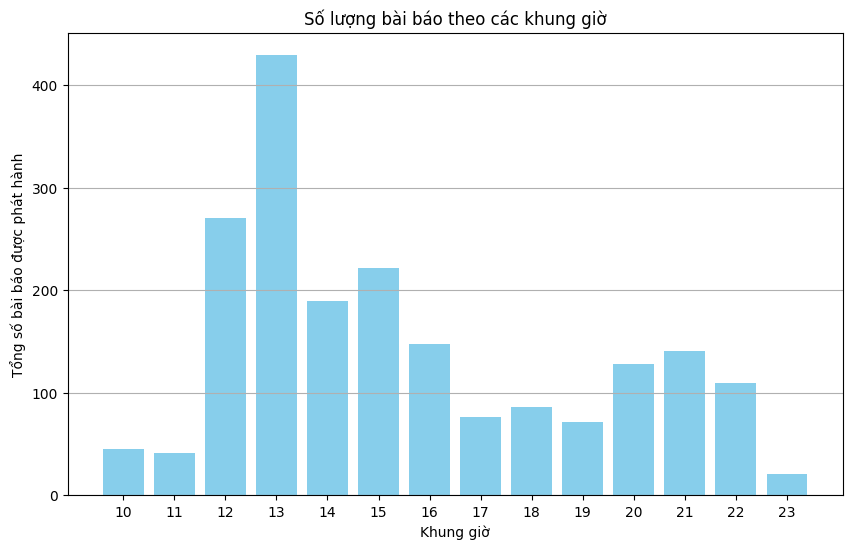

In [98]:
# Vẽ biểu đồ thống kê
print('Thống kê số lượng bài báo theo các khung giờ')
result_df = spark_df_news \
    .withColumn('hour',f.hour('new_time_published')) \
    .groupBy('hour') \
    .agg(f.count('new_id').alias('Tổng số bài báo được phát hành')) \
    .withColumnRenamed('hour','Khung giờ') \
    .orderBy('Khung giờ') \
    .toPandas()

plt.figure(figsize=(10,6))
plt.bar(result_df['Khung giờ'],result_df['Tổng số bài báo được phát hành'],color = 'skyblue')
plt.xlabel('Khung giờ')
plt.ylabel('Tổng số bài báo được phát hành')
plt.title('Số lượng bài báo theo các khung giờ')
plt.xticks(result_df['Khung giờ'])
plt.grid(axis='y')

# Hiển thị chart
plt.show()